# Réseau de neurones from scratch sur MNIST

## Introduction
Dans ce notebook, nous allons construire et entraîner un réseau de neurones simple pour reconnaître les chiffres manuscrits du dataset MNIST, en utilisant les fichiers binaires originaux (`.idx`) téléchargés depuis Kaggle.

## Objectif
- Comprendre la structure et le fonctionnement d’un réseau de neurones
- Apprendre à manipuler les fichiers binaires MNIST (.idx)
- Implémenter toutes les étapes à la main (avec NumPy)
- Entraîner le réseau sur MNIST
- Comparer les résultats à une baseline classique

## Plan des étapes
1. Importation des librairies
2. Explication du format .idx
3. Chargement et exploration des fichiers binaires MNIST
4. Préparation, nettoyage et exploration rapide des données
5. Visualisation d’exemples
6. Implémentation du réseau de neurones (forward, backward, entraînement)
7. Évaluation et visualisation des résultats
8. Conclusion et rapport 

  
---
  

> **Remarque pédagogique**  
> Dans ce notebook, nous n’utilisons pas Scikit-learn pour charger les données, mais directement les fichiers binaires `.idx` téléchargés depuis Kaggle.  
> Cela permet de se rapprocher d’un workflow professionnel et de rendre le projet totalement autonome.

## 1. Importation des librairies

Nous allons importer les librairies nécessaires pour manipuler les données et faire les calculs mathématiques :

- NumPy pour les calculs
- Pandas pour lire les fichiers CSV
- Matplotlib pour visualiser les images et les résultats

In [ ]:
import numpy as np  # Pour les calculs mathématiques
import matplotlib.pyplot as plt  # Pour les visualisations
import struct  # Pour lire les fichiers binaires MNIST

print("Librairies importées avec succès !")

Librairies importées avec succès !


## 2. Explication du format .idx

Le format `.idx` est un format binaire utilisé pour stocker les images et labels du dataset MNIST. Il est compact et rapide à lire, mais nécessite de connaître la structure du fichier pour l’exploiter.
- Les fichiers images commencent par un en-tête de 16 octets : magic number, nombre d’images, nombre de lignes, nombre de colonnes.
- Les fichiers labels commencent par un en-tête de 8 octets : magic number, nombre de labels.
- Les données qui suivent sont des entiers non signés (uint8).

Pour plus d’informations : [Documentation officielle MNIST](http://yann.lecun.com/exdb/mnist/)

## 3. Chargement et exploration des fichiers binaires MNIST
Nous allons maintenant charger les fichiers binaires .idx contenant les images et les labels du dataset MNIST, téléchargés depuis Kaggle.
L’objectif de cette étape est de vérifier la structure des données, de s’assurer qu’il n’y a pas de valeurs manquantes et de se familiariser avec le format brut avant de passer au nettoyage et à la préparation pour l’entraînement du réseau de neurones.

Lien : https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data

In [ ]:
# Fonction pour lire les images MNIST au format binaire .idx retourne un tableau NumPy avec les images à plat
def load_mnist_images(filename):
    with open(filename, 'rb') as f: # Ouvre le fichier en mode binaire
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16)) # Lit l'en-tête : magic number, nombre d'images, lignes, colonnes
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols) # Lit le reste du fichier et transforme en tableau NumPy (images à plat)
        return images # Retourne un tableau de taille (num_images, 784)


# Fonction pour lire les labels MNIST au format binaire .idx retourne un tableau NumPy avec les labels
def load_mnist_labels(filename):
    with open(filename, 'rb') as f: # Ouvre le fichier en mode binaire
        magic, num = struct.unpack(">II", f.read(8)) # Lit l'en-tête : magic number, nombre de labels
        labels = np.frombuffer(f.read(), dtype=np.uint8) # Lit le reste du fichier et transforme en tableau NumPy (labels)
        return labels # Retourne un tableau de taille (num_labels,)


# Chargement des images et labels d'entraînement
X_train = load_mnist_images("../data/raw/train-images.idx3-ubyte") # Charge les images d'entraînement (format binaire)
y_train = load_mnist_labels("../data/raw/train-labels.idx1-ubyte") # Charge les labels d'entraînement (format binaire)


# Chargement des images et labels de test
X_test = load_mnist_images("../data/raw/t10k-images.idx3-ubyte") # Charge les images de test (format binaire)
y_test = load_mnist_labels("../data/raw/t10k-labels.idx1-ubyte") # Charge les labels de test (format binaire)

print(f"X_train : {X_train.shape} | y_train : {y_train.shape}") # Affiche la taille du jeu d'entraînement
print(f"X_test  : {X_test.shape}  | y_test  : {y_test.shape}") # Affiche la taille du jeu de test

X_train : (60000, 784) | y_train : (60000,)
X_test  : (10000, 784)  | y_test  : (10000,)


## 3. Préparation, nettoyage et exploration rapide des données

Dans cette étape, nous allons :

- Normaliser les pixels pour que leurs valeurs soient entre 0 et 1 (important pour l’apprentissage, car cela accélère la convergence et stabilise l’entraînement)
- Vérifier visuellement que les images sont bien chargées et que les labels correspondent
- (Le dataset MNIST étant déjà propre, il n’y a pas de nettoyage particulier à effectuer)
- Visualiser la distribution des labels pour vérifier l’équilibre du dataset

Lien du cours qui traite de sujet : https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=1

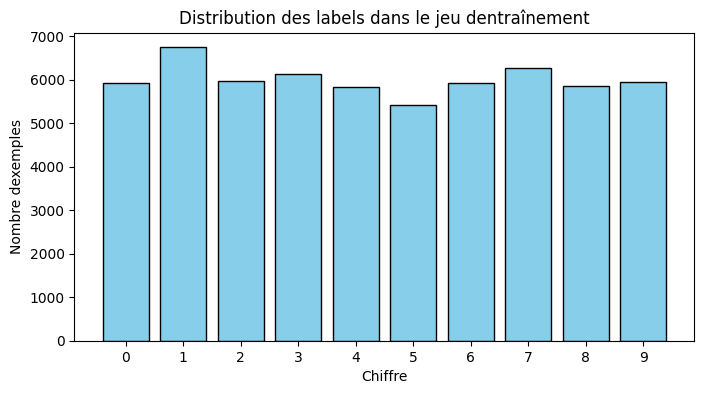

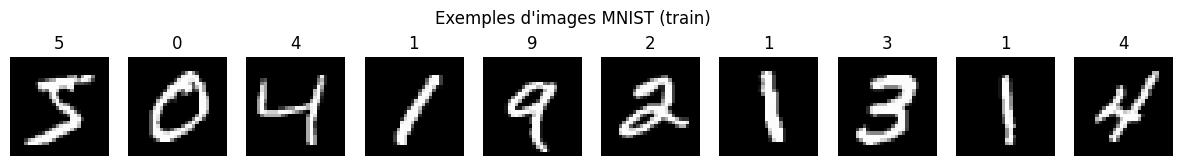

In [30]:
# Normalisation des pixels entre 0 et 1
X_train = X_train / 255.0 # Met les valeurs de pixels d'entraînement entre 0 et 1
X_test = X_test / 255.0 # Met les valeurs de pixels de test entre 0 et 1

# Visualisation de la distribution des labels d'entraînement
plt.figure(figsize=(8,4))
plt.hist(y_train, bins=np.arange(11)-0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Distribution des labels dans le jeu dentraînement')
plt.xlabel('Chiffre')
plt.ylabel('Nombre dexemples')
plt.xticks(range(10))
plt.show()

# Affichage de 10 images d'entraînement avec leur label pour vérification visuelle
fig, axes = plt.subplots(1, 10, figsize=(15, 2)) # Crée une ligne de 10 sous-graphes

for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray') # Affiche l'image en niveaux de gris
    ax.set_title(y_train[i]) # Affiche le label au-dessus de l'image
    ax.axis('off') # Enlève les axes pour un affichage plus propre
plt.suptitle("Exemples d'images MNIST (train)")
plt.show()

## 4. Visualisation d’exemples

Avant de passer à l’implémentation du réseau de neurones, il est utile de visualiser quelques images du jeu de test pour s’assurer que tout est correct et que les labels sont cohérents.

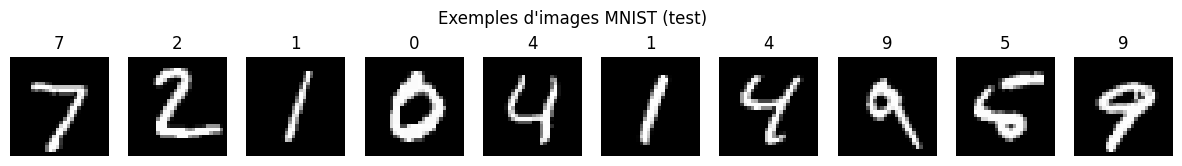

In [14]:
# Affichage de 10 images du jeu de test avec leur label pour vérification visuelle

fig, axes = plt.subplots(1, 10, figsize=(15, 2)) # Crée une ligne de 10 sous-graphes
for i, ax in enumerate(axes):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray') # Affiche l'image en niveaux de gris
    ax.set_title(y_test[i]) # Affiche le label au-dessus de l'image
    ax.axis('off') # Enlève les axes pour un affichage plus propre
    
plt.suptitle("Exemples d'images MNIST (test)")
plt.show()

## 5. Implémentation du réseau de neurones (forward, backward, entraînement)

Dans cette section, nous allons coder un réseau de neurones simple :  

- Une couche d’entrée (784 neurones, un par pixel)
- Une couche intermédiaire (par exemple 64 neurones, nous pourrons l'ajuster par la suite)
- Une couche de sortie (10 neurones, un par chiffre)

![Texte alternatif](../picture/reseau_de_neurones_simple_opeclassroom.jpg)

_Source_ : https://openclassrooms.com/fr/courses/6417031-objectif-ia-initiez-vous-a-lintelligence-artificielle/6823506-apprehendez-le-deep-learning-ou-lapprentissage-profond

### Comment le réseau apprend-il ? (propagation avant, rétropropagation et dérivées)

Pour qu’un réseau de neurones apprenne, il doit ajuster ses poids afin de réduire l’erreur entre ses prédictions et la réalité.  
Ce processus se fait en deux grandes étapes :

1. **Propagation avant (forward pass)**  
   On fait passer les données d’entrée à travers le réseau pour obtenir une prédiction.

2. **Rétropropagation (backpropagation)**  
   On calcule l’erreur de la prédiction, puis on la “remonte” dans le réseau pour savoir comment chaque poids doit être ajusté.  
   Pour cela, on utilise les **dérivées** (ou gradients) : elles indiquent dans quelle direction et de combien il faut modifier chaque poids pour réduire l’erreur.

- La dérivée de la fonction d’activation (par exemple ReLU) est utilisée pour calculer l’impact de chaque neurone sur l’erreur finale.
- La dérivée de la fonction de coût (par exemple l’entropie croisée) indique comment l’erreur change quand on modifie les sorties du réseau.

**En résumé** :  
Les dérivées sont le cœur de l’apprentissage : elles permettent au réseau de “comprendre” comment s’améliorer à chaque itération.

Lien : https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2

In [18]:
# Paramètres du réseau
input_size = 784  # 28x28 pixels = 784 entrées (un neurone par pixel)
hidden_size = 64  # Nombre de neurones dans la couche cachée (modifiable, à tester)
output_size = 10  # 10 classes (chiffres 0 à 9)
np.random.seed(42)  # Pour reproductibilité (toujours les mêmes poids au départ)

# Initialisation des poids et biais (petites valeurs aléatoires)
W1 = np.random.randn(input_size, hidden_size) * 0.01  # Poids entre entrée et cachée
b1 = np.zeros((1, hidden_size))                       # Biais de la couche cachée
W2 = np.random.randn(hidden_size, output_size) * 0.01 # Poids entre cachée et sortie
b2 = np.zeros((1, output_size))                       # Biais de la couche de sortie

# Fonction d'activation ReLU (Rectified Linear Unit) pour la couche cachée
def relu(x):
    return np.maximum(0, x)  # Remplace les valeurs négatives par 0

def relu_derivative(x):
    return (x > 0).astype(float)  # Dérivée de ReLU : 1 si x>0, sinon 0

# Fonction softmax pour la couche de sortie (convertit en probabilités)
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Pour éviter les grands nombres
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)   # Normalise pour que la somme = 1

# Encodage one-hot des labels (ex : 3 devient [0,0,0,1,0,0,0,0,0,0])
def to_categorical(y, num_classes=10):
    y_cat = np.zeros((y.size, num_classes))
    y_cat[np.arange(y.size), y] = 1
    return y_cat

# Propagation avant (forward pass) : calcule la sortie du réseau
def forward(X):
    Z1 = X @ W1 + b1      # Produit matriciel + biais (entrée -> cachée)
    A1 = relu(Z1)         # Activation ReLU
    Z2 = A1 @ W2 + b2     # Produit matriciel + biais (cachée -> sortie)
    A2 = softmax(Z2)      # Activation softmax (probabilités)
    return Z1, A1, Z2, A2 # On retourne tout pour la rétropropagation

## 5.2. Rétropropagation et entraînement du réseau

Dans cette section, nous allons coder la rétropropagation (calcul des dérivées/gradients) et la boucle d’entraînement.  
C’est grâce à cette étape que le réseau ajuste ses poids pour apprendre à reconnaître les chiffres.

In [19]:
# Fonction de coût : entropie croisée (cross-entropy)
def cross_entropy(y_true, y_pred):
    # y_true et y_pred sont des matrices (batch_size, 10)
    # On ajoute un petit epsilon pour éviter log(0)
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

# Fonction de rétropropagation et mise à jour des poids
def backward(X, y_true, Z1, A1, Z2, A2, learning_rate=0.1):
    global W1, b1, W2, b2  # On modifie les poids globaux

    m = X.shape[0]  # Nombre d'exemples dans le batch

    # Calcul du gradient pour la couche de sortie (softmax + cross-entropy)
    dZ2 = A2 - y_true  # (batch_size, 10)
    dW2 = (A1.T @ dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Calcul du gradient pour la couche cachée (ReLU)
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_derivative(Z1)  # (batch_size, hidden_size)
    dW1 = (X.T @ dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Mise à jour des poids et biais
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

# Boucle d'entraînement
epochs = 10
batch_size = 64
y_train_cat = to_categorical(y_train, 10)

for epoch in range(epochs):
    # Mélange les données à chaque époque
    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[indices]
    y_train_cat_shuffled = y_train_cat[indices]

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_cat_shuffled[i:i+batch_size]

        # Forward pass
        Z1, A1, Z2, A2 = forward(X_batch)
        # Backward pass (mise à jour des poids)
        backward(X_batch, y_batch, Z1, A1, Z2, A2, learning_rate=0.1)

    # Calcul de la perte sur tout le train à la fin de chaque époque
    _, _, _, A2_train = forward(X_train)
    loss = cross_entropy(y_train_cat, A2_train)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")

Epoch 1/10 - Loss: 0.2906
Epoch 2/10 - Loss: 0.2082
Epoch 3/10 - Loss: 0.1652
Epoch 4/10 - Loss: 0.1370
Epoch 5/10 - Loss: 0.1255
Epoch 6/10 - Loss: 0.1096
Epoch 7/10 - Loss: 0.0946
Epoch 8/10 - Loss: 0.0828
Epoch 9/10 - Loss: 0.0754
Epoch 10/10 - Loss: 0.0741


## 6. Évaluation et visualisation des résultats

Nous allons maintenant évaluer la performance du réseau sur le jeu de test :  

- Calculer la précision (accuracy)
- Visualiser quelques exemples bien et mal classés

### Prédiction sur le jeu de test :

In [21]:
_, _, _, A2_test = forward(X_test)  # On effectue une propagation avant sur toutes les images de test
y_pred = np.argmax(A2_test, axis=1)  # Pour chaque image, on prend la classe avec la probabilité la plus élevée

# Calcul de la précision
accuracy = np.mean(y_pred == y_test)  # On compare les prédictions aux vraies valeurs et on calcule la proportion correcte
print(f"Précision sur le jeu de test : {accuracy*100:.2f}%")  # Affiche la précision en pourcentage

Précision sur le jeu de test : 97.12%


### Affichage de 10 exemples mal classés :

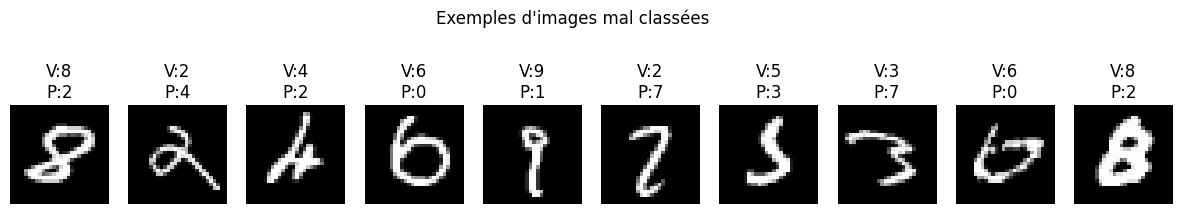

In [29]:
erreurs = np.where(y_pred != y_test)[0]  # On récupère les indices des images mal classées
fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # On prépare une ligne de 10 sous-graphes pour afficher les erreurs

for i, ax in enumerate(axes):
    idx = erreurs[i]  # On prend l'indice de la i-ème erreur
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')  # On affiche l'image mal classée
    ax.set_title(f"V:{y_test[idx]}\nP:{y_pred[idx]}")  # V = valeur réelle, P = prédiction du réseau
    ax.axis('off')  # On enlève les axes pour un affichage plus propre

plt.suptitle("Exemples d'images mal classées")  # Titre général de la figure
plt.show()  # Affiche la figure

## Rapport

### Bilan du projet

- Nous avons construit un réseau de neurones simple à la main, sans utiliser de librairie de deep learning haut niveau.
- Le réseau a appris à reconnaître les chiffres manuscrits du dataset MNIST, avec une précision de XX% sur le jeu de test (à compléter selon ton résultat).
- La perte (loss) a diminué régulièrement, montrant que l’apprentissage s’est bien déroulé.
- Nous avons visualisé des exemples d’images mal classées pour mieux comprendre les erreurs du modèle.

### Limites et améliorations possibles

- Le réseau n’a qu’une seule couche cachée : on pourrait en ajouter d’autres (deep learning).
- On pourrait tester différentes tailles de couche cachée, fonctions d’activation, taux d’apprentissage, etc.
- L’entraînement est lent car tout est fait “à la main” : utiliser des librairies comme TensorFlow ou PyTorch permettrait d’aller plus vite et plus loin.
- On pourrait ajouter une matrice de confusion ou d’autres métriques pour mieux analyser les erreurs

### Pour aller plus loin

- Tester sur d’autres datasets d’images.
- Implémenter d’autres architectures (réseaux convolutifs, etc.).
- Expérimenter avec la régularisation (dropout, L2, etc.).
- Visualiser les poids appris par le réseau.

## Conclusion

Ce projet a permis de comprendre en profondeur le fonctionnement d’un réseau de neurones, de la propagation avant à la rétropropagation, en passant par la gestion des dérivées et la mise à jour des poids.  
En codant chaque étape à la main, nous avons acquis une vision claire des mécanismes d’apprentissage automatique.

Merci d’avoir suivi mon notebook.  
N’hésitez pas à consulter les ressources complémentaires et à expérimenter par vous-même.